# What were the longest and shortest journal article titles in NHB at 2022?

## Choosing the appropriate data source

### Things to consider

* What type of data are we interested in for the given meta-research study? For example, we could be interested in the publication date, author names, number of citations, and the full text of the paper, etc.
  * Scientific databases vary in the types of data they collect and make available to users.
  * We may have to use multiple databases to get all the desired variables.
  * Check the documentation of the databases for further details.
  * Not all databases have the same data quality!
* Is the database of your choice proprietary?
  * Some databases are free to use, while others require a subscription. Ask your institution's librarian to find out whether you have access to the database.
  * Some databases are free to use online (e.g. dimensions.ai) but the API access is restricted. Not the best option if one wants reproducible workflows.
* Is there a readily available API and preferably a wrapper library in your programming language of choice to access the database easily?
  * Using an API to access the data in the database is a secure, structured, scalable, and reproducible method compared to other ways (downloading unstructured data manually for example).
  * Sometimes it is necessary to create custom solutions to solve our problems but in most cases, there is no need to reinvent the wheel.
    * Most programming languages that data scientists use (e.g. Python or R) most likely already have wrapper libraries to use the API with ease. 

### Example

* We use the [PubMed](https://pubmed.ncbi.nlm.nih.gov/) and the [PubMed Central](https://www.ncbi.nlm.nih.gov/pmc/) databases in our example.

## Setting up the project

### Things to consider

* Good practices for collaboration with other and future self.
* What programming language to use?
  * Mostly R or Python.
* Package versioning and virtual environments
  * Package versions can change over time hindering reproducibility of the code.
  * Other packages installed on your machine can influence the results you get when running your code.
  * This could be a source of error and it is hard to track.   
* What IDE?
  * Provides useful tools and integrated solutions to simplify workflow.
  * Jupyter notebook is a popular choice for Python
    * Markdown, Python codechunks and inline code.
    * Writing human-readable output documents with reproducible code.
* README.md
  * First document to check for a given project.
  * Describes the project and folder structure on a high-level.
  * Describes the steps to reproduce the project.
* License
* Version control
  * Tracking changes without clutter.
  * Helps in identifying mistakes and correcting them.
  * Helps with collaboration on code.
  * Using it locally or publishing it to an online repository (e.g. Github or Gitlab).
  * Not all files have to be tracked (use `.gitignore` to exclude files from tracking).
* Project folder structure
  * What goes where within the project?
  * Is there any field-wise or programming language specific standard that we can follow?
    * For example, R packages have a well-documented standard structure. There are other packages that we can take advantage of, which build on that structure. Easier to understand by others without prior knowledge of our project.

### Example

* We use Python in our example. [See this tutorial for help on how to install it.](https://realpython.com/installing-python/).
* Check if Python is successfully installed by using `python -version` or `python3 -V` in your terminal.

* Create a folder for the project `mkdir [folder_name]`
* Open the folder `cd [folder_name]`

* Install `pipenv` to create a virtual working environment by typing `pip install pipenv` in your terminal
  * From now on, all packages should by installed by using the virtual environment, i.e. `pipenv install [package_name]`

* Install `jupyter notebook` by using `pipenv install jupyter`
* Run the `jupyter notebook` by `pipenv run jupyter notebook`

* Initialize the repository as a git repository `git init`
* Add the `.gitignore` file.
* Stage all the files for tracking `git add .`
* Commit the initial changes `git commit -m "init"`

## Writing the code

### Things to consider

* The first version of the code does not have to be perfect.
* We cannot anticipate everything.
* We should first focus on:
  * Creating broad code structure that focuses on funcionality.
  * Identifying potential sources of errors.
* Errors will happen, so it is imporant to catch the errors and log everything so we can learn from them.
* Break down code to functional sections (e.g. retreiving paper ids, getting their metadata, filtering the metadata, etc.)
* We can update the code iteratively to be more precise (within reasonable limits...).

### Example

#### Setup

Load packages.

In [159]:
from Bio import Entrez
import pandas as pd
import matplotlib.pyplot as plt

Introducing myself to Entrez according to PubMed API rules.

In [5]:
Entrez.email = "marton.balazs.kovacs@gmail.com"

#### Retrieving the sample

In [50]:
# Constructing the query
query = f"nature human behaviour[Journal] AND 2022[Publication Date]"

# Create the search handle
handle = Entrez.esearch(db="pubmed", term=query, retmode="xml")

# Rerieve the results
all_results = Entrez.read(handle)
handle.close()

In [51]:
all_results.keys()

dict_keys(['Count', 'RetMax', 'RetStart', 'IdList', 'TranslationSet', 'QueryTranslation'])

In [52]:
# The number of papers published in plos one in 2022
all_results['Count']

'266'

In [53]:
len(all_results['IdList'])

20

The number of ids is not equal to the number of matches!

According to the API documentation the maximum number of results returned is 10thousand. By setting the `retmax` parameter we can get all the results.

In [55]:
# Constructing the query
query = f"nature human behaviour[Journal] AND 2022[Publication Date]"

# Create the search handle
handle = Entrez.esearch(db="pubmed", term=query, retmode="xml", retmax=9999)

# Rerieve the results
results = Entrez.read(handle)
handle.close()

# Save all the ids
paper_ids = results['IdList']
len(paper_ids)

266

#### Get the paper information

If we post the ids first on PubMed the retrieval will be faster!

In [102]:
handle = Entrez.epost(db="pubmed", id=",".join(paper_ids))
post = Entrez.read(handle)
handle.close()
post

{'QueryKey': '1', 'WebEnv': 'MCID_655e743ed5165e2be56638bd'}

In [105]:
# Setting variables for iteration
batch_size = 10
results = []
total_count = len(paper_ids)

for start in range(0, total_count, batch_size):
    # Set end for iteration
    end = min(total_count, start + batch_size)
    # Print progress
    print(f"Going to download record {start + 1} to {end}")
    # Fetch pubmed article data
    handle = Entrez.efetch(
        db="pubmed",
        retmode="XML",
        retstart=start,
        retmax=batch_size,
        webenv=post["WebEnv"],
        query_key=post["QueryKey"]
    )
    
    # Read returned XML as python object
    data = Entrez.read(handle)
    fetch_handle.close()
    results.append(data)

Going to download record 1 to 10
Going to download record 11 to 20
Going to download record 21 to 30
Going to download record 31 to 40
Going to download record 41 to 50
Going to download record 51 to 60
Going to download record 61 to 70
Going to download record 71 to 80
Going to download record 81 to 90
Going to download record 91 to 100
Going to download record 101 to 110
Going to download record 111 to 120
Going to download record 121 to 130
Going to download record 131 to 140
Going to download record 141 to 150
Going to download record 151 to 160
Going to download record 161 to 170
Going to download record 171 to 180
Going to download record 181 to 190
Going to download record 191 to 200
Going to download record 201 to 210
Going to download record 211 to 220
Going to download record 221 to 230
Going to download record 231 to 240
Going to download record 241 to 250
Going to download record 251 to 260
Going to download record 261 to 266


#### Understanding the structure of the returned data

In [106]:
len(results)

27

The `results` array contains 27 batches of PubMed articles. Each batch contains on object of two arrays: 'PubmedBookArticle' and 'PubmedArticle'.

Let's look at the structure of the first batch.

In [83]:
results[0]

{'PubmedBookArticle': [], 'PubmedArticle': [{'MedlineCitation': DictElement({'KeywordList': [], 'CitationSubset': ['IM'], 'OtherID': [], 'GeneralNote': [], 'OtherAbstract': [], 'SpaceFlightMission': [], 'PMID': StringElement('36577898', attributes={'Version': '1'}), 'DateCompleted': {'Year': '2023', 'Month': '02', 'Day': '28'}, 'DateRevised': {'Year': '2023', 'Month': '03', 'Day': '09'}, 'Article': DictElement({'ArticleDate': [DictElement({'Year': '2022', 'Month': '12', 'Day': '28'}, attributes={'DateType': 'Electronic'})], 'ELocationID': [StringElement('10.1038/s41562-022-01489-2', attributes={'EIdType': 'doi', 'ValidYN': 'Y'})], 'Language': ['eng'], 'Journal': {'ISSN': StringElement('2397-3374', attributes={'IssnType': 'Electronic'}), 'JournalIssue': DictElement({'Volume': '7', 'Issue': '2', 'PubDate': {'Year': '2023', 'Month': 'Feb'}}, attributes={'CitedMedium': 'Internet'}), 'Title': 'Nature human behaviour', 'ISOAbbreviation': 'Nat Hum Behav'}, 'ArticleTitle': 'Deep learning revea

How many articles were in the first batch?

In [89]:
len(results[0]['PubmedArticle'])

10

Let's see the first article in the first batch.

In [91]:
results[0]['PubmedArticle'][0]

{'MedlineCitation': DictElement({'KeywordList': [], 'CitationSubset': ['IM'], 'OtherID': [], 'GeneralNote': [], 'OtherAbstract': [], 'SpaceFlightMission': [], 'PMID': StringElement('36577898', attributes={'Version': '1'}), 'DateCompleted': {'Year': '2023', 'Month': '02', 'Day': '28'}, 'DateRevised': {'Year': '2023', 'Month': '03', 'Day': '09'}, 'Article': DictElement({'ArticleDate': [DictElement({'Year': '2022', 'Month': '12', 'Day': '28'}, attributes={'DateType': 'Electronic'})], 'ELocationID': [StringElement('10.1038/s41562-022-01489-2', attributes={'EIdType': 'doi', 'ValidYN': 'Y'})], 'Language': ['eng'], 'Journal': {'ISSN': StringElement('2397-3374', attributes={'IssnType': 'Electronic'}), 'JournalIssue': DictElement({'Volume': '7', 'Issue': '2', 'PubDate': {'Year': '2023', 'Month': 'Feb'}}, attributes={'CitedMedium': 'Internet'}), 'Title': 'Nature human behaviour', 'ISOAbbreviation': 'Nat Hum Behav'}, 'ArticleTitle': 'Deep learning reveals what vocal bursts express in different cu

In [108]:
results[0]['PubmedArticle'][0]['MedlineCitation']['Article'].keys()

dict_keys(['ArticleDate', 'ELocationID', 'Language', 'Journal', 'ArticleTitle', 'Pagination', 'Abstract', 'AuthorList', 'PublicationTypeList'])

#### Extracting the measures needed

We can extract the results into a dataframe.

In [141]:
df = pd.DataFrame(columns=["pubmedid", "title", "message"])

In [142]:
for data in results: 
    # Get the PubmedArticle array
    # We do not care about books now
    pubmedarticles = data['PubmedArticle']
    
    # Process pubmedarticles if there is any
    if len(pubmedarticles)>0:
        for article in pubmedarticles:
            # Get pubmedid of the result
            pubmed_id = str(article['MedlineCitation']['PMID'])
            # Check if there is a title
            if 'ArticleTitle' not in article['MedlineCitation']['Article']:
                df = pd.concat([df, pd.DataFrame([{"pubmedid": pubmed_id, "title": pd.NA, "message": 'No title found.'}])])
            else :
                df = pd.concat([df, pd.DataFrame([{"pubmedid": pubmed_id, "title": article['MedlineCitation']['Article']['ArticleTitle'], "message": pd.NA}])])
                

Number of extracted articles:

In [143]:
len(df)

266

#### Data wrangling

Number of titles extracted:

In [135]:
len(df['title'].notna())

266

In [154]:
df.head()

,pubmedid,title,message,n_char
0,36577898,Deep learning reveals what vocal bursts expres...,<NA>,70
0,36550220,The transmission of pottery technology among p...,<NA>,83
0,36482079,A genetically informed Registered Report on ad...,<NA>,92
0,36482078,Cooking and future risk of all-cause and cardi...,<NA>,67
0,36471010,Reducing discrimination against job seekers wi...,<NA>,77


Let's see the errors if there are any.

In [150]:
df[df['message'].notna()]

,pubmedid,title,message


In [149]:
df['message'].isna().sum()

266

Add a new column that contains the number of characters in the title column.

In [155]:
df['n_char'] = df['title'].str.len()
# df['message'].apply(lambda x: len(str(x)) if pd.notna(x) else pd.NA)

#### Results

In [157]:
f"The longest title was {df['n_char'].max()} characters long while the shortest title was {df['n_char'].min()} characters long."

'The longest title was 162 characters long while the shortest title was 21 characters long.'

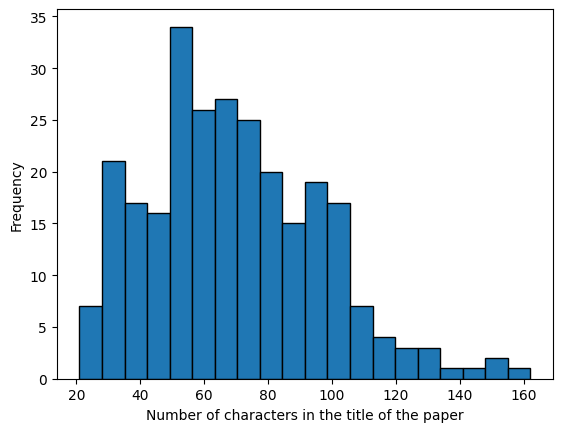

In [163]:
plt.hist(df['n_char'].dropna(), bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Number of characters in the title of the paper')
plt.ylabel('Frequency')

# Show the plot
plt.show()